In [1]:
import json
import openeo
import numpy as np
from utils import openeoMap, OnnxInference, PowerScalers, reproject_bbox

import matplotlib
import matplotlib.pyplot as plt
import rasterio
import requests
import os

# Authentication

In [2]:
# Connect and authenticate
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


# Execute UDP

## Region selection

In [3]:
# draw a bounding box on the map to select your area of interest
# you can uncheck the imagery layer to see the underlying map

eoMap = openeoMap(center=[50.84, 4.35], zoom=11)
eoMap.map


Map(center=[50.84, 4.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [4]:
bbox = eoMap.getBbox()
print('Current spatial bounding box specified in longitude/latitude:', np.round(bbox,2))


Current spatial bounding box specified in longitude/latitude: [ 4.36 50.79  4.46 50.85]


In [5]:
# it might be useful to reproject the bounding box to local utm coords
# not strictly necessary, but it might avoid problems at the edge of the region
bbox, crs_epsg = reproject_bbox(bbox)
print(f'New spatial bounding box specified in epsg {crs_epsg}: {np.round(bbox,2)}')

spatial_extent = dict(zip(["west", "south", "east", "north"], bbox))
spatial_extent["crs"] = crs_epsg


New spatial bounding box specified in epsg 32631: [ 595520. 5627800.  602960. 5633680.]


## Date selection

In [6]:
# select date to process. Expressed as an interval, but only the first (found) date will be used
year = 2022
month = 5

startdate = "{}-{:02d}-{:02d}".format(year, month, 1)
enddate = "{}-{:02d}-{:02d}".format(year, month, 5)
temporal_extent = [startdate, enddate]

print('Chosen date will be the first possible date within the interval:', temporal_extent)

Chosen date will be the first possible date within the interval: ['2022-05-01', '2022-05-05']


## Execute

In [7]:
job_options = {
    "executor-memory": "2G",
    "executor-memoryOverhead": "4G",
    "executor-cores": "2",
}

In [8]:
inference_result = connection.datacube_from_process(
    process_id="corsa_compression",
    spatial_extent=spatial_extent,
    namespace="vito",
    temporal_extent = temporal_extent)

job = inference_result.execute_batch(job_options=job_options,title="corsa_compression")


0:00:00 Job 'j-240701425a8941c3bef77acb22699f93': send 'start'
0:00:24 Job 'j-240701425a8941c3bef77acb22699f93': queued (progress 0%)
0:00:30 Job 'j-240701425a8941c3bef77acb22699f93': queued (progress 0%)
0:00:37 Job 'j-240701425a8941c3bef77acb22699f93': queued (progress 0%)
0:00:45 Job 'j-240701425a8941c3bef77acb22699f93': queued (progress 0%)
0:00:55 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:01:07 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:01:23 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:01:42 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:02:06 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:02:36 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:03:13 Job 'j-240701425a8941c3bef77acb22699f93': running (progress N/A)
0:04:00 Job 'j-240701425a8941c3bef77acb22699f93': finished (progress 100%)


In [9]:
outputs = job.get_results()
outputs.get_metadata()

{'assets': {'level0_20m_2022-05-02Z.tif': {'eo:bands': [{'name': 'level_0'}],
   'file:size': 166513,
   'href': 'https://openeo.vito.be/openeo/1.2/jobs/j-240701425a8941c3bef77acb22699f93/results/assets/NjNkMjYxMjJhZWMxZmM1YWUyYzE2YTA0NTU3MGU0ZDkwZTg5ZmIzYTUxMDgxYzBkOWQ2MDQ3YzI3MGY3Mjk0MEBlZ2kuZXU=/c5c9a97568570d80ddf310a295ceb654/level0_20m_2022-05-02Z.tif?expires=1720439360',
   'proj:bbox': [595520.0, 5627800.0, 602960.0, 5633680.0],
   'proj:epsg': 32631,
   'proj:shape': [294, 372],
   'raster:bands': [{'name': 'level_0',
     'statistics': {'maximum': 511.0,
      'mean': 224.03957281838,
      'minimum': 0.0,
      'stddev': 157.21373554937,
      'valid_percent': 100.0}}],
   'roles': ['data'],
   'title': 'level0_20m_2022-05-02Z.tif',
   'type': 'image/tiff; application=geotiff'},
  'level1_40m_2022-05-02Z.tif': {'file:size': 30894,
   'href': 'https://openeo.vito.be/openeo/1.2/jobs/j-240701425a8941c3bef77acb22699f93/results/assets/NjNkMjYxMjJhZWMxZmM1YWUyYzE2YTA0NTU3MGU0ZDkwZ

In [10]:
# download results
outputs.download_files('./corsa_compression')

[PosixPath('corsa_compression/level0_20m_2022-05-02Z.tif'),
 PosixPath('corsa_compression/level1_40m_2022-05-02Z.tif'),
 PosixPath('corsa_compression/result.json'),
 PosixPath('corsa_compression/job-results.json')]

# Local reconstruction

We use the publicly available decoder to inspect some of the reconstructed images

In [37]:
# download decoder from vito artifactory
artifactory = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/corsa-compression"

def download_from_artifactory(rel_path, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    r = requests.get(f'{artifactory}/{rel_path}', allow_redirects=True)
    if not os.path.exists(out_path):
        if r.ok:
            with open(out_path, 'wb') as f:
                f.write(r.content)
            print(f" {rel_path} downloaded")
        else:
            print(r.text)
            raise Exception(f"Could not download {rel_path}")
    else:
        print(f" {rel_path} already downloaded")


download_from_artifactory("decoding.zip", out_path="./decoding.zip")


# unzip
import zipfile
with zipfile.ZipFile('./decoding.zip', 'r') as zip_ref:
    zip_ref.extractall('./corsa_compression')



 decoding.zip downloaded


In [38]:
# load the compressed indices, both level0 (20m) and level1 (40m) are required
ids_l0 = rasterio.open('./corsa_compression/level0_20m_2022-05-02Z.tif').read()[0]
ids_l1 = rasterio.open('./corsa_compression/level1_40m_2022-05-02Z.tif').read()[0]

# ids_l0 = rasterio.open('./corsa_compression/res20m_2020-01-26Z.tif').read()[0]
# ids_l1 = rasterio.open('./corsa_compression/res40m_2020-01-26Z.tif').read()[0]
print('shape of level 0 and level 1 indices', ids_l0.shape, ids_l1.shape)



shape of level 0 and level 1 indices (294, 372) (147, 186)


Warning 1: ./corsa_compression/level0_20m_2022-05-02Z.tif:Nonstandard tile width 120, convert file
Warning 1: ./corsa_compression/level0_20m_2022-05-02Z.tif:Nonstandard tile length 120, convert file
Warning 1: ./corsa_compression/level1_40m_2022-05-02Z.tif:Nonstandard tile width 120, convert file
Warning 1: ./corsa_compression/level1_40m_2022-05-02Z.tif:Nonstandard tile length 120, convert file


Text(0.5, 1.0, 'Level 1 indices')

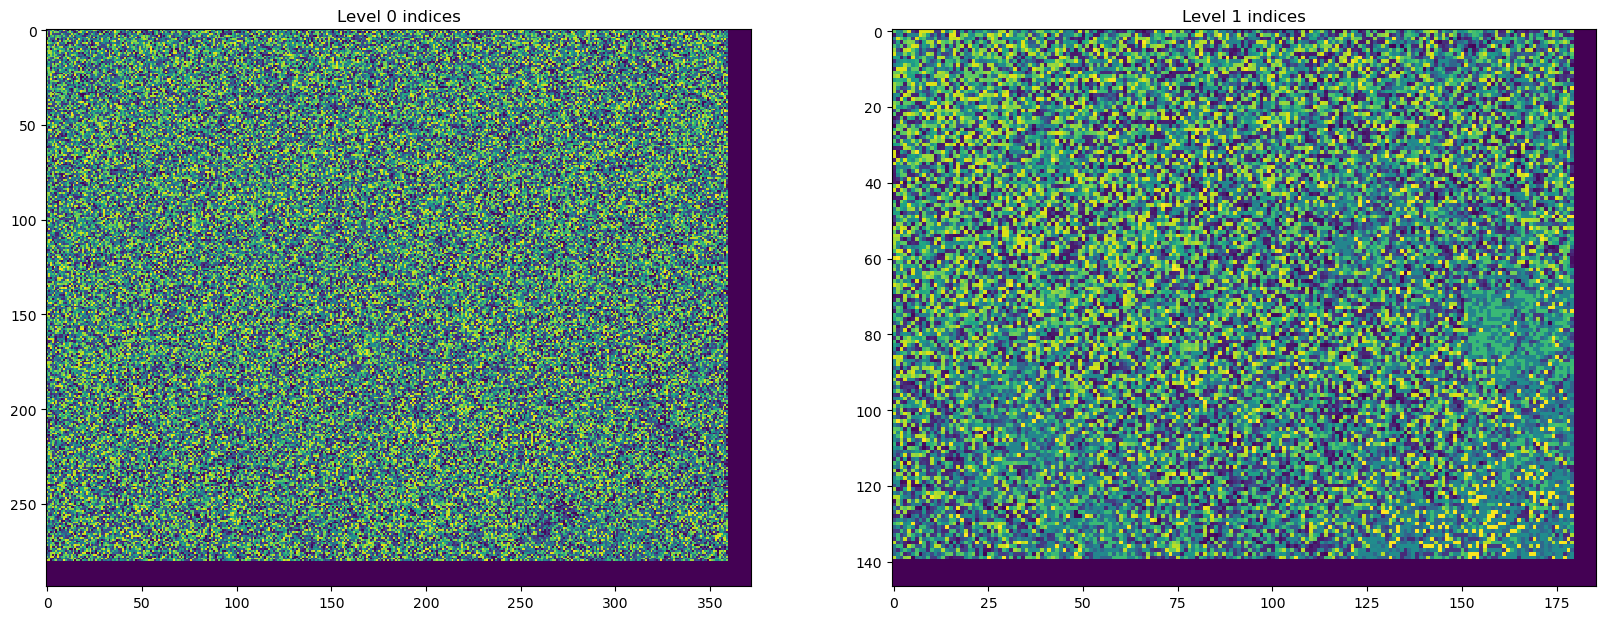

In [39]:
# Visualise level 0, and level 1 indices
# The indices are integers and hard to interpret like this

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(ids_l0, interpolation='nearest')
ax1.set_title('Level 0 indices')
ax2.imshow(ids_l1, interpolation='nearest')
ax2.set_title('Level 1 indices')

In [40]:
# replace nans by 0
ids_l0 = np.nan_to_num(ids_l0)
ids_l1 = np.nan_to_num(ids_l1)

In [41]:
# to avoid boundary problems, we crop the shape of level 0 to a multiple of 60 and level 1 to a multiple of 30
print('original shape', ids_l0.shape, ids_l1.shape)

ids_l0 = ids_l0[:ids_l0.shape[0]//60*60, :ids_l0.shape[1]//60*60]
ids_l1 = ids_l1[:ids_l1.shape[0]//30*30, :ids_l1.shape[1]//30*30]
print('new shape', ids_l0.shape, ids_l1.shape)

original shape (294, 372) (147, 186)
new shape (240, 360) (120, 180)


In [42]:
# let the decoder do its work

recon = OnnxInference().recon('./corsa_compression/decoder.onnx',ids_l0, ids_l1)



processing patches 4 by 6 ...


  0%|          | 0/24 [00:00<?, ?it/s]

In [43]:
# the model was trained on normalised Sentinel-2 images. So we need to scale the reconstruction back to the orignal range
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

ps = PowerScalers(path_to_scalers='./corsa_compression/scalers', bands=bands)
recon_unscaled = ps.unscale(recon, bands=bands)

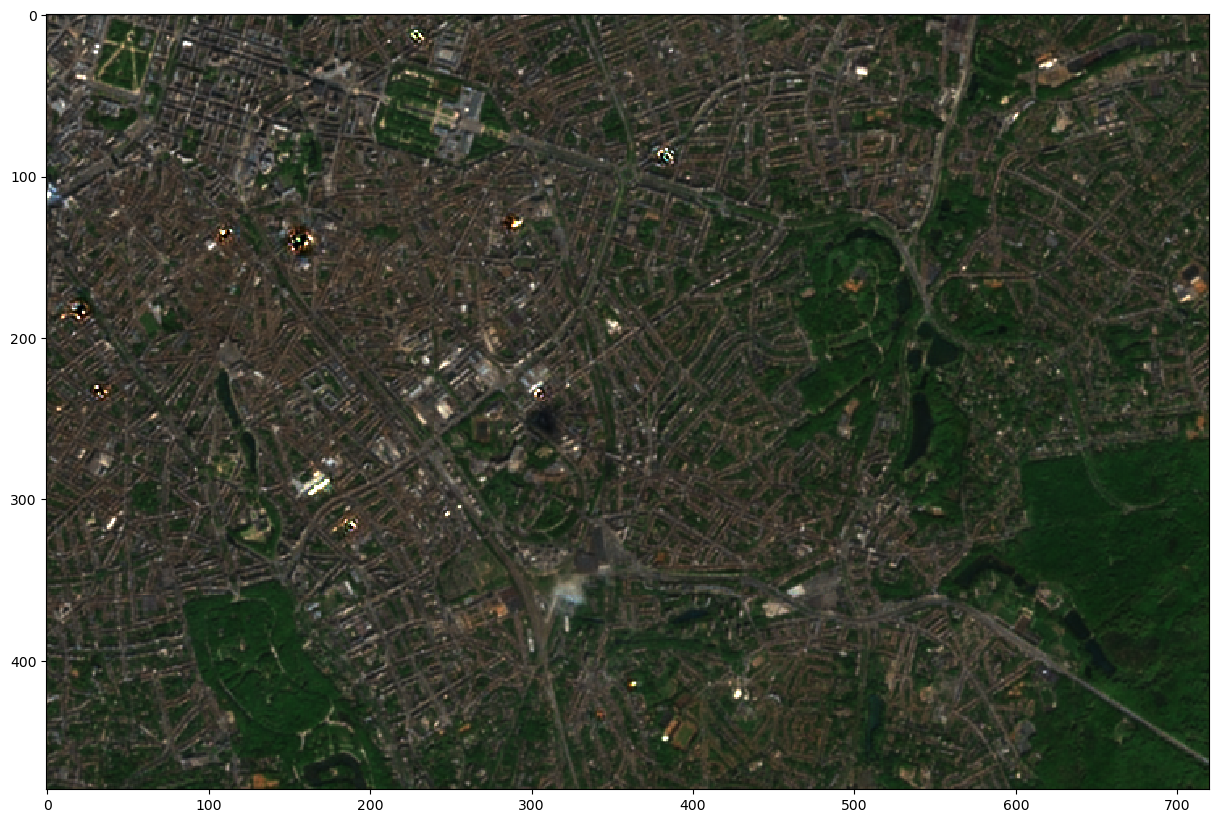

In [44]:
plt.figure(figsize=(15,15))
rgb = np.clip(recon_unscaled[[2,1,0]]/4000,0,1).transpose(1,2,0)
plt.imshow(rgb, interpolation='nearest')

# Downstream application

The compressed indices are not only good for storing high volume datasets, they are excellent to use in downstream AI applications. By mapping the indices back to the codebook vectors, we get high dimensional features containing all the information about the image. New AI models can be efficiently trained directly on top of these features for e.g. change detection, landcover classification, etc.

In this demo we use a simple landcover classification model. 

In [45]:
# load the compressed indices, both level0 (20m) and level1 (40m) are required
ids_l0 = rasterio.open('./corsa_compression/level0_20m_2022-05-02Z.tif').read()[0]
ids_l1 = rasterio.open('./corsa_compression/level1_40m_2022-05-02Z.tif').read()[0]
print('shape of level 0 and level 1 indices', ids_l0.shape, ids_l1.shape)

shape of level 0 and level 1 indices (294, 372) (147, 186)


Warning 1: ./corsa_compression/level0_20m_2022-05-02Z.tif:Nonstandard tile width 120, convert file
Warning 1: ./corsa_compression/level0_20m_2022-05-02Z.tif:Nonstandard tile length 120, convert file
Warning 1: ./corsa_compression/level1_40m_2022-05-02Z.tif:Nonstandard tile width 120, convert file
Warning 1: ./corsa_compression/level1_40m_2022-05-02Z.tif:Nonstandard tile length 120, convert file


In [47]:
# the codebook is a dictionary that maps the indices (integers) back to the codebook vector (vector of dimension 128)

# codebook_path = '/home/vito/luytsa/openmmv1x/trained_models/openeo/pretrain_BEN_10-20m_512-128/onnx/codebook_vectors.json'
codebook_path = './corsa_compression/codebook_vectors.json'
with open(codebook_path) as f:
    codebook = json.load(f)
    codebook = {k: {int(kk): tuple(vv) for kk, vv in v.items()} for k, v in codebook.items()}

print(codebook.keys())
print('The shape of first level0 codebook vector is', np.array(codebook['level0'][0]).shape)

dict_keys(['level0', 'level1'])
The shape of first level0 codebook vector is (128,)


In [48]:
# write a function that maps an array of indices (the compressed files) back to an array of codebook vectors

def map_indices_to_codebook(indices, codebook):
    vec = np.zeros((128,) + indices.shape, dtype=np.float32)
    for i in range(0, indices.shape[0]):
        for j in range(0, indices.shape[1]):
            vec[:,i,j] = codebook[indices[i,j]]
    return vec

In [49]:
vec_l0 = map_indices_to_codebook(ids_l0, codebook['level0'])
vec_l1 = map_indices_to_codebook(ids_l1, codebook['level1'])

In [50]:
print('original shape', vec_l0.shape, vec_l1.shape)
vec_l0 = vec_l0[:,:vec_l0.shape[-2]//60*60, :vec_l0.shape[-1]//60*60]
vec_l1 = vec_l1[:,:vec_l1.shape[-2]//30*30, :vec_l1.shape[-1]//30*30]
print('cropped shape', vec_l0.shape, vec_l1.shape)

original shape (128, 294, 372) (128, 147, 186)
cropped shape (128, 240, 360) (128, 120, 180)


In [51]:
model_path = './corsa_compression/landcover.onnx'
preds = OnnxInference().lc(model_path, vec_l0, vec_l1)
preds = np.argmax(preds.squeeze(), axis=0)

processing patches 4 by 6 ...


  0%|          | 0/24 [00:00<?, ?it/s]

In [56]:
# Define colors for the landocver classes

lc_classes = {0:'Water',1:'Trees',2:'Grass',3:'Flooded vegetation',4:'Crops', 5:'Scrub',6:'Built Area',7:'Bare', 8:'Snow/Ice',9:'Cloud'}
lc_color_map = {0:'blue',1:'green',2:'lime',3:'cyan',4:'peru', 5:'olive',6:'red',7:'yellow',8:'white',9:'grey'}
cmap = (matplotlib.colors.ListedColormap(lc_color_map.values()))
norm = matplotlib.colors.Normalize(vmin=0, vmax=9)
patches = [matplotlib.patches.Patch(color=cmap(norm(u)), label=lc_classes[u]) for u in np.unique(preds)]



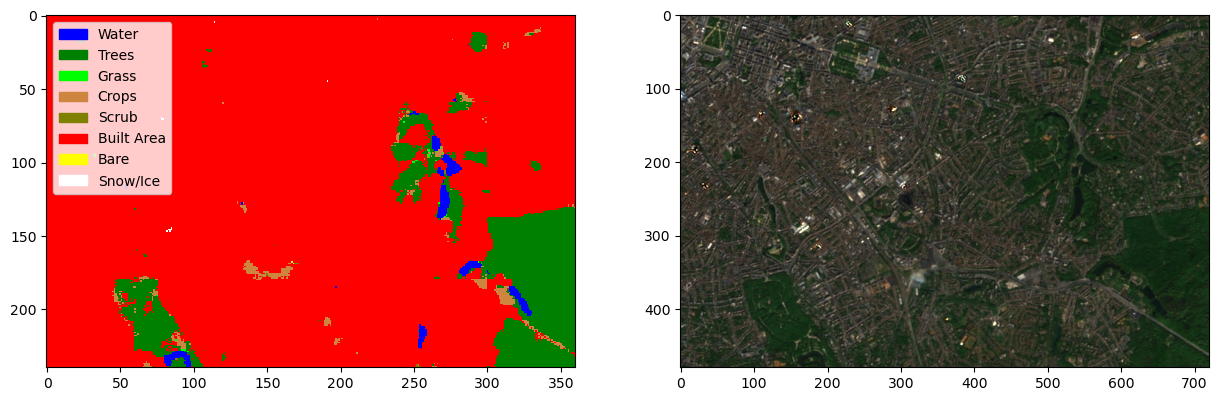

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.imshow(preds,cmap=cmap, vmin=0, vmax=10, interpolation='nearest')
ax2.imshow(rgb)
ax1.legend(handles=patches, loc='upper left')